In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import numpy as np
import os
import PIL.Image
import pandas as pd
from pathlib import Path
import json
import collections
import cv2

import helper


PATH = Path('../pascal')


train_json = json.load((PATH/'pascal_train2007.json').open())


IMAGE_PATH = PATH/'VOCdevkit/Voc2007/JPEGImages'


In [2]:

IMAGE = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES = 'categories'
FILE_NAME = 'file_name'
ID = 'id'
IMAGE_ID = 'image_id'
BBOX = 'bbox'
CATEGORY_ID = 'category_id'
CATEGORY_NAME = 'name'

CATEGORY_DICT = {o[ID]: o[CATEGORY_NAME] for o in train_json[CATEGORIES]}
TRAIN_IMAGE = {o[ID]: o[FILE_NAME] for o in train_json[IMAGE]}
TRAIN_ID = {o[ID] for o in train_json[IMAGE]}

TRAIN_ANNOTAIONS = collections.defaultdict(lambda: [])

for i in train_json[ANNOTATIONS]:
    if not i['ignore']:
        b = i[BBOX]
        b = helper.convert_hw2bb(b)
        TRAIN_ANNOTAIONS[i[IMAGE_ID]].append((b, i[CATEGORY_ID]))
        


In [3]:
def draw_idx(i):
    im_a = TRAIN_ANNOTAIONS[i]
    img = helper.open_image(IMAGE_PATH/TRAIN_IMAGE[i])
    helper.draw_img(img, im_a, CATEGORY_DICT)

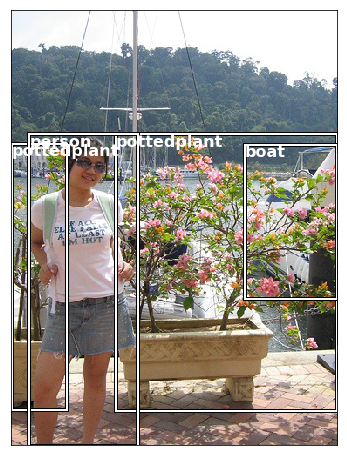

In [4]:
draw_idx(73)

In [5]:
def get_largest_ann(b):
	b = sorted(b, key = lambda x: np.product(
		x[0][-2:] - x[0][:2]), reverse = True)
	return b[0]

TRAIN_LARGEST_ANNOTATIONS = {a: get_largest_ann(b) for a,b in TRAIN_ANNOTAIONS.items()}

In [6]:
(PATH/'csv_folder').mkdir(exist_ok = True)
CSV_BB = PATH/'csv_folder/largest_bb.csv'

CSV_CAT = PATH/'csv_folder/cat.csv'


df_cat = pd.DataFrame({'file_name' : [TRAIN_IMAGE[o] for o in TRAIN_ID],
					'category': [CATEGORY_DICT[TRAIN_LARGEST_ANNOTATIONS[o][1]] for o in TRAIN_ID]},
					columns = ['file_name', 'category'])


df_cat.to_csv(CSV_CAT, index = False)

bb = np.array([TRAIN_LARGEST_ANNOTATIONS[o][0] for o in TRAIN_ID])

bb_str = [' '.join(str(p) for p in o) for o in bb]

df_bb = pd.DataFrame({'file_name': [TRAIN_IMAGE[o] for o in TRAIN_ID],
					'bbs': bb_str},
					columns = ['file_name', 'bbs'])

df_bb.to_csv(CSV_BB, index = False)

In [7]:

from custom_dataset import *
from custom_transform import *

In [8]:
image_train_tfms = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor()])

bbox_train_tfms = transforms.Compose([ResizeIB((224, 224)),
                                     RandomFlipIB(),
                                     ConvertTensor()])

In [9]:
image_data = PascalImage(csv_dir = 'csv_folder/cat.csv', img_dir= IMAGE_PATH, transforms= image_train_tfms)

In [10]:
bb_data = BoundingBox(csv_dir= 'csv_folder/largest_bb.csv', img_dir= IMAGE_PATH, transforms= bbox_train_tfms)

In [11]:
data = CombineData(img_data= image_data, bb_data= bb_data)

In [12]:
data_dl = DataLoader(data, batch_size= 64, shuffle= True)

In [13]:
model = models.vgg16(pretrained= True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
classifier = nn.Sequential(
	nn.Linear(in_features = 25088, out_features = 256),
	nn.ReLU(),
	nn.BatchNorm1d(256),
	nn.Dropout(0.5),
	nn.Linear(in_features = 256, out_features = 4 + 20))

In [15]:
model.classifier = model.classifier

In [16]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
def loss(pred, label):
	bb_l, c_l = label
	bb_p, c_p = pred[:,:4], pred[:,4:]

	return F.l1_loss(bb_p, bb_l) + F.cross_entropy(c_p, c_l)*20


def get_reg_loss(pred, label):
	bb_l, c_l = label
	bb_p, c_p = pred[:,:4], pred[:,4:]

	return F.l1_loss(bb_p, bb_l).data


def get_cat_loss(pred, label):
	bb_l, c_l = label
	bb_p, c_p = pred[:,:4], pred[:,4:]

	return F.cross_entropy(c_p, c_l)


def get_accuracy(pred, label):
	_, c_l = label
	c_p = pred[:,4:]

	return accuracy(c_p, c_l)

In [18]:
from loss import *
from train import *

In [19]:
data_dl

In [20]:
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

In [ ]:
train(epochs= 1,model= model ,optimizer= optimizer, train_dataloader= data_dl)

{'Detection overall loss': 383.4380187988281, 'L1 Loss': tensor(120.7804), 'Cat Loss': tensor(13.1329, grad_fn=<NllLossBackward>), 'Accuracy': tensor(0.)}
{'Detection overall loss': 195.5823974609375, 'L1 Loss': tensor(118.2586), 'Cat Loss': tensor(3.8662, grad_fn=<NllLossBackward>), 'Accuracy': tensor(0.3281)}
